In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Text_Classification/KP_dataset_df_current.csv')

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend, models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
layers = keras.layers
models = keras.models

from sklearn.preprocessing import LabelBinarizer, LabelEncoder # Used for encoding Labels
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt

import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

Epoch 1/50
2/2 [==============================] - 0s 89ms/step - loss: 1.9120 - accuracy: 0.1600 - val_loss: 1.8519 - val_accuracy: 0.4167
Epoch 2/50
2/2 [==============================] - 0s 22ms/step - loss: 0.8180 - accuracy: 0.9400 - val_loss: 1.7389 - val_accuracy: 0.5000
Epoch 3/50
2/2 [==============================] - 0s 17ms/step - loss: 0.4433 - accuracy: 0.9800 - val_loss: 1.0852 - val_accuracy: 0.7500
Epoch 4/50
2/2 [==============================] - 0s 18ms/step - loss: 0.2774 - accuracy: 1.0000 - val_loss: 0.7696 - val_accuracy: 0.9167
Epoch 5/50
2/2 [==============================] - 0s 10ms/step - loss: 0.2111 - accuracy: 1.0000 - val_loss: 0.7574 - val_accuracy: 0.8333
Epoch 6/50
2/2 [==============================] - 0s 10ms/step - loss: 0.1739 - accuracy: 1.0000 - val_loss: 0.8613 - val_accuracy: 0.8333
Epoch 7/50
2/2 [==============================] - 0s 11ms/step - loss: 0.1595 - accuracy: 1.0000 - val_loss: 0.9451 - val_accuracy: 0.8333
Epoch 8/50
2/2 [===========

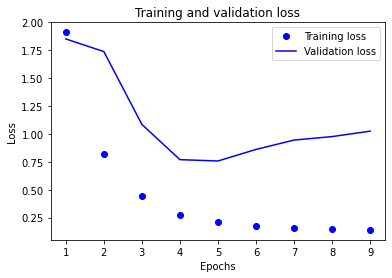

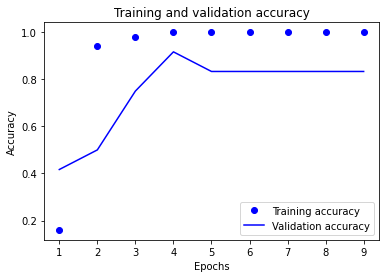

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state = 42)

train_cat=train['category_id']
test_cat=test['category_id']
train_text=train['LemmatizedcleanText']
test_text=test['LemmatizedcleanText']

max_words=10000

tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words,char_level=False, oov_token='unknown')

tokenize.fit_on_texts(train_text) # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

word_index = tokenize.word_index
#dict(list(word_index.items())[0:10])

# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Edit epoch for best results
# Training for more epochs will likely lead to overfitting on this dataset

batch_size = 64
epochs = 50
drop_ratio = 0.3

# Build the model
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(512,kernel_regularizer = regularizers.l1(0.00001)))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))
#optimizerA=Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks = [EarlyStopping(monitor='accuracy', patience = 5, restore_best_weights=True)])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [5]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,batch_size=32, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 2ms/step - loss: 1.1430 - accuracy: 0.7241
Test loss: 1.1430081129074097
Test accuracy: 0.7241379022598267


Confusion matrix, without normalization
[[2 1 1 0 0 0]
 [0 3 0 0 0 0]
 [0 1 3 0 0 0]
 [0 1 0 3 0 0]
 [0 0 0 1 9 0]
 [2 0 1 0 0 1]]


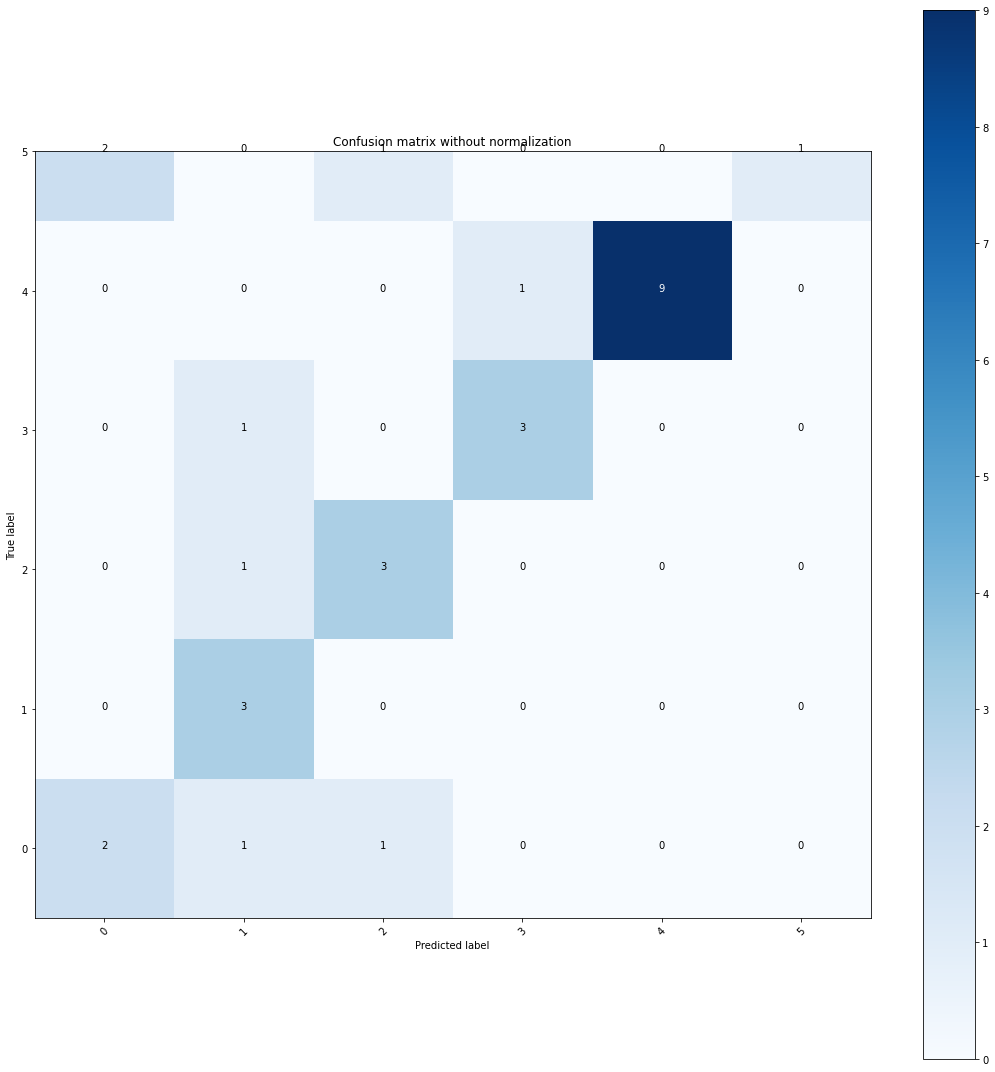

In [6]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,normalize=False
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    #plt.xlim(-0.5, len(np.unique(y))-0.5)
    #plt.ylim(len(np.unique(y))-0.5, -0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(15,15))
plt.ylim(-0.5, 4.5)
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix without normalization",normalize=False)
plt.show()

In [8]:
# Create a new pandas dataframe "category_id_df", which only has unique Categories, also sorting this list in order of category_id values
 
category_id_df = df[['Label', 'category_id']].drop_duplicates().sort_values('category_id')
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)

In [9]:
print('accuracy %s' % accuracy_score(y_pred_1d, y_test_1d))

print(classification_report(y_test_1d, y_pred_1d,target_names=list(id_to_category.values())))


accuracy 0.7241379310344828
                    precision    recall  f1-score   support

            Claims       0.50      0.50      0.50         4
HealthCareDelivery       0.50      1.00      0.67         3
        Membership       0.60      0.75      0.67         4
          Pharmacy       0.75      0.75      0.75         4
ProductandBenefits       1.00      0.90      0.95        10
ProviderandNetwork       1.00      0.25      0.40         4

          accuracy                           0.72        29
         macro avg       0.72      0.69      0.66        29
      weighted avg       0.79      0.72      0.72        29

